In [1]:
pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
df = fetch_ucirepo(id=352)

# data (as pandas dataframes)
X = df.data.features
y = df.data.targets

# metadata
print(df.metadata)

# variable information
print(df.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

In [7]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# Use the features data from the fetched dataset
df = df.copy()

print(df.info(), df.isnull().mean()*100)
df = df[df['Quantity'] > 0]  # remove returns
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

<class 'pandas.core.frame.DataFrame'>
Index: 531285 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  530693 non-null  object 
 1   Quantity     531285 non-null  int64  
 2   InvoiceDate  531285 non-null  object 
 3   UnitPrice    531285 non-null  float64
 4   CustomerID   397924 non-null  float64
 5   Country      531285 non-null  object 
 6   TotalValue   531285 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 32.4+ MB
None Description     0.111428
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     25.101593
Country         0.000000
TotalValue      0.000000
dtype: float64


**Cleaning & Validation**

In [16]:
# Remove rows with negative or zero quantity/unit price (returns or data issues)
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Drop transactions with missing CustomerID (guest sales)
df = df.dropna(subset=['CustomerID'])

# Remove duplicates
df = df.drop_duplicates()
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

print("Cleaned shape:", df.shape)


Cleaned shape: (392617, 10)


/tmp/ipython-input-1419357008.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalValue'] = df['Quantity'] * df['UnitPrice']


In [33]:
# Drop transactions with missing CustomerID (guest sales)
df = df.dropna(subset=['CustomerID'])

# Calculate TotalValue
df['TotalValue'] = df['Quantity'] * df['UnitPrice']

# Sales category based on order value
df['SalesCategory'] = pd.cut(df['TotalValue'],
                             bins=[0, 20, 100, 500, np.inf],
                             labels=['Low','Mid','High','Very High'], ordered=True)

# Order size category based on quantity
df['OrderSize'] = pd.cut(df['Quantity'],
                         bins=[0,5,20,100,np.inf],
                         labels=['Small','Medium','Large','Bulk'], ordered=True)

# Customer purchase frequency category
cust_counts = df.groupby('CustomerID')['InvoiceNo'].nunique()
# Use pd.cut with custom bins for customer frequency
bins = [0, 2, 5, np.inf] # Example bins: 1-2 invoices, 3-5 invoices, 6+ invoices
labels = ['Occasional','Frequent','VIP']
freq_cats = pd.cut(cust_counts, bins=bins, labels=labels, right=True)
df['CustomerFreq'] = df['CustomerID'].map(freq_cats)

In [9]:
# Binning
df['SalesCategory'] = pd.cut(df['TotalValue'], bins=[0,20,100,1000, np.inf],
                             labels=['Low','Mid','High','Very High'], ordered=True)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Hour'] = df['InvoiceDate'].dt.hour
df['Weekday'] = df['InvoiceDate'].dt.day_name()

In [10]:
# Value counts and group-by
print(df['SalesCategory'].value_counts())
avg_by_country = df.groupby('Country')['TotalValue'].mean().sort_values(ascending=False).head(10)
print(avg_by_country)


SalesCategory
Low          429797
Mid           86753
High          13166
Very High       388
Name: count, dtype: int64
Country
Netherlands    120.798282
Australia      116.895620
Japan          116.561900
Singapore       95.852658
Sweden          85.096075
Hong Kong       55.252817
Denmark         49.882474
Lithuania       47.458857
Bahrain         41.896667
Lebanon         37.641778
Name: TotalValue, dtype: float64


**Descriptive Analysis & Grouping**

In [34]:
# Frequency counts
print(df['SalesCategory'].value_counts())
print("\nAverage Order Value by Customer Frequency:\n", df.groupby('CustomerFreq')['TotalValue'].mean())

# Country-level metrics
country_metrics = df.groupby('Country').agg({
    'InvoiceNo':'nunique',
    'TotalValue':'sum',
    'CustomerID':'nunique'
}).rename(columns={'InvoiceNo':'NumOrders','CustomerID':'NumCustomers'})
country_metrics['SalesPerCustomer'] = country_metrics['TotalValue'] / country_metrics['NumCustomers']
print("\nTop countries by Sales Per Customer:\n", country_metrics.sort_values('SalesPerCustomer', ascending=False).head())


SalesCategory
Low          312205
Mid           74022
High          10744
Very High       913
Name: count, dtype: int64

Average Order Value by Customer Frequency:
 CustomerFreq
Occasional    14.644472
Frequent      15.615520
VIP           23.332886
Name: TotalValue, dtype: float64

Top countries by Sales Per Customer:
              NumOrders  TotalValue  NumCustomers  SalesPerCustomer
Country                                                           
EIRE               319   250285.22             3      83428.406667
Netherlands        101   284661.54             9      31629.060000
Australia           69   137077.27             9      15230.807778
Singapore           10     9120.39             1       9120.390000
Sweden              46    36595.91             8       4574.488750


/tmp/ipython-input-1872111476.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print("\nAverage Order Value by Customer Frequency:\n", df.groupby('CustomerFreq')['TotalValue'].mean())


Text(0.5, 1.0, 'Spend Category by Weekday')

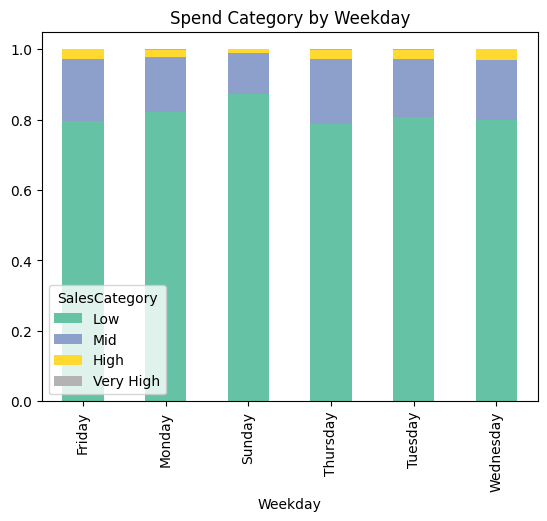

In [11]:
# Cross-tab
ct = pd.crosstab(df['Weekday'], df['SalesCategory'], normalize='index')
ct.plot(kind='bar', stacked=True, colormap='Set2'); plt.title("Spend Category by Weekday")


Text(0.5, 1.0, 'Sales by Hour of Day')

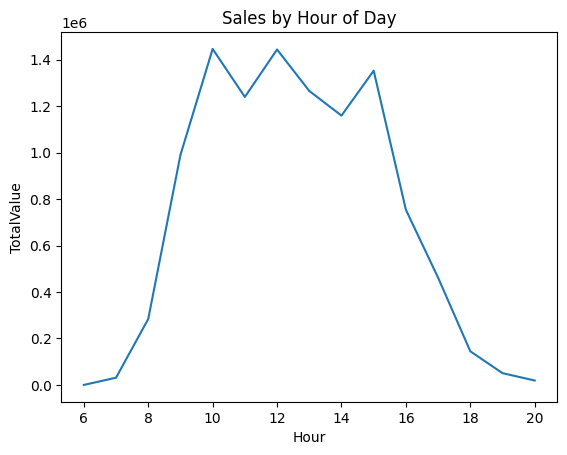

In [12]:
# Temporal pattern
sns.lineplot(data=df.groupby('Hour')['TotalValue'].sum()); plt.title("Sales by Hour of Day")


**Temporal Purchase Patterns**  

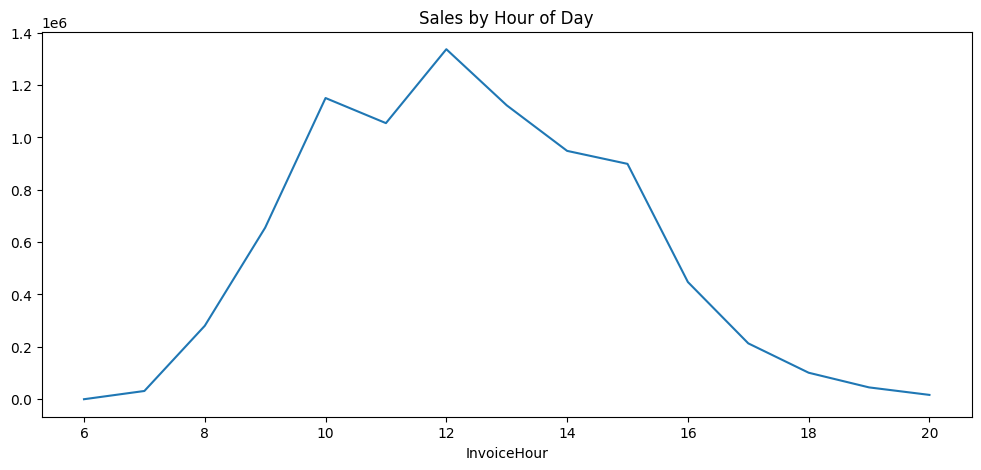

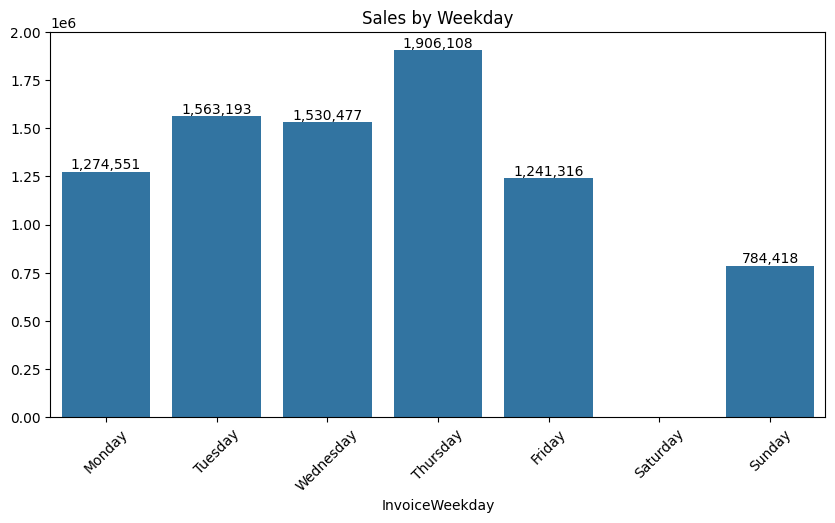

In [36]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceWeekday'] = df['InvoiceDate'].dt.day_name()

hourly = df.groupby('InvoiceHour')['TotalValue'].sum()
weekday = df.groupby('InvoiceWeekday')['TotalValue'].sum()
weekday = weekday.reindex(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

plt.figure(figsize=(12,5))
sns.lineplot(x=hourly.index, y=hourly.values)
plt.title("Sales by Hour of Day")

plt.figure(figsize=(10,5))
sns.barplot(x=weekday.index, y=weekday.values)
plt.xticks(rotation=45)
plt.title("Sales by Weekday")
for p in plt.gca().patches:
    plt.gca().annotate(f"{int(p.get_height()):,}", (p.get_x()+p.get_width()/2, p.get_height()), ha='center', va='bottom')
plt.show()

**Outliers & Distribution Analysis**  

**Cross-Tabulation & Categorical Visualization**  

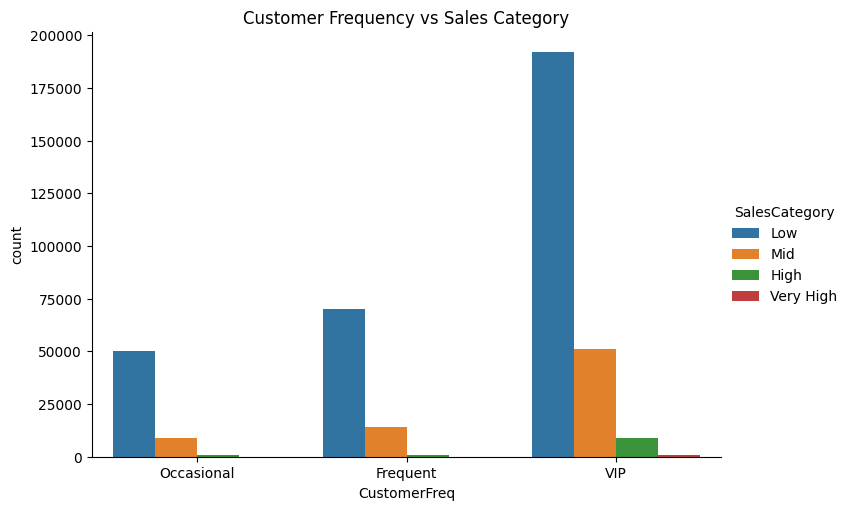

In [40]:


# SalesCategory by CustomerFreq
sns.catplot(x='CustomerFreq', hue='SalesCategory', kind='count', data=df, height=5, aspect=1.5)
plt.title("Customer Frequency vs Sales Category")
plt.show()


Number of extremely high value orders: 4056
Correlation Matrix:
             Quantity  UnitPrice  TotalValue
Quantity    1.000000  -0.010389    0.639659
UnitPrice  -0.010389   1.000000   -0.467433
TotalValue  0.639659  -0.467433    1.000000


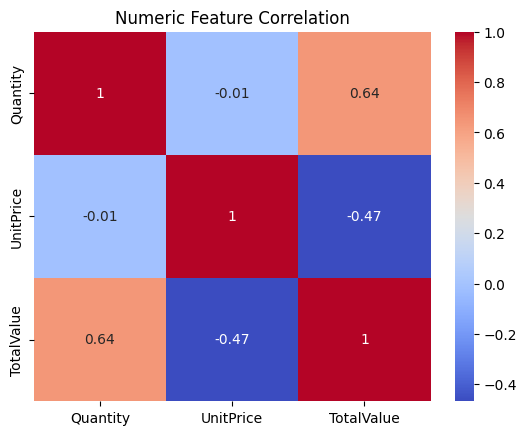

In [41]:
# Outliers
high_txn = df[df['TotalValue'] > df['TotalValue'].quantile(0.99)]
print("Number of extremely high value orders:", len(high_txn))

sub = df[['Quantity','UnitPrice','TotalValue']].sample(10000)
print("Correlation Matrix:\n", sub.corr())
sns.heatmap(sub.corr(), annot=True, cmap='coolwarm')
plt.title("Numeric Feature Correlation")
plt.show()


            Quantity  UnitPrice  TotalValue
Quantity    1.000000  -0.029309    0.578098
UnitPrice  -0.029309   1.000000    0.332147
TotalValue  0.578098   0.332147    1.000000


<Axes: >

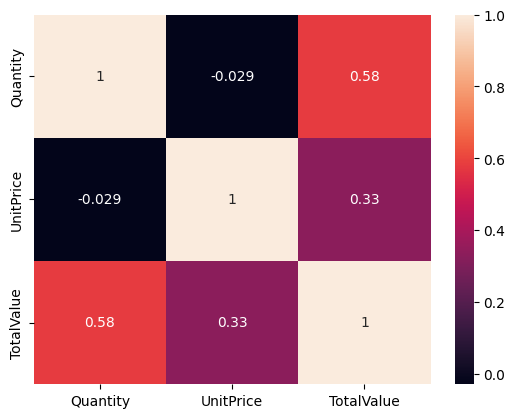

In [14]:
# Correlation
sub = df[['Quantity', 'UnitPrice', 'TotalValue']].sample(10000)
print(sub.corr())
sns.heatmap(sub.corr(), annot=True)


In [15]:
# Hypothesis check
country_avg = avg_by_country
print(f"Top country by average order value: {country_avg.idxmax()} (${country_avg.max():.2f})")


Top country by average order value: Netherlands ($120.80)


In [42]:
# Hypothesis: Bulk orders have significantly higher average value than small orders
bulk_mean = df[df['OrderSize']=='Bulk']['TotalValue'].mean()
small_mean = df[df['OrderSize']=='Small']['TotalValue'].mean()
print(f"Mean Bulk Order: ${bulk_mean:.2f}, Mean Small Order: ${small_mean:.2f}")

# Statistical test (t-test)
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(df[df['OrderSize']=='Bulk']['TotalValue'],
                          df[df['OrderSize']=='Small']['TotalValue'], equal_var=False)
print(f"T-test Bulk vs Small: t={t_stat:.2f}, p-value={p_val:.3f}")


Mean Bulk Order: $389.77, Mean Small Order: $8.81
T-test Bulk vs Small: t=9.45, p-value=0.000
